# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Section 1:Business Understaning

The starbucks data give a situation about Sale Promotion with cupon. It give the customers a discount of BOGO(buy one get one free), which will prompt the sale if the customer use it. Customer get discount, starbuck get sale promotion and build customer potential consumption pattern.

For accuracy we should find out how to use the cupon:
1. Is it benifit for starbucks
2. if it worthy enough, who should we give the cupon.

# Section 2:Data Understaning

1. Reading in data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import re
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

2. we will take a look at the data first.

In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


portfolio seems no need for cleaning.

In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [7]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


2. Data Cleaning

In [9]:
profile['income_na'] = profile['income'].isna()
profile['income'].fillna(0, inplace = True)

In [10]:
profile.head()

,gender,age,id,became_member_on,income,income_na
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0.0,False
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,False
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,0.0,False
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,False
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,0.0,False


(array([ 611.,  697.,  649.,  789.,  972., 1082., 1607., 1776., 1727.,
        1530., 1174.,  857.,  591.,  375.,  256.,  105.,   27.,    0.,
           0., 2175.]),
 array([ 18.,  23.,  28.,  33.,  38.,  43.,  48.,  53.,  58.,  63.,  68.,
         73.,  78.,  83.,  88.,  93.,  98., 103., 108., 113., 118.]),
 <BarContainer object of 20 artists>)

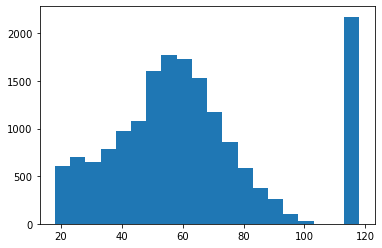

In [11]:
plt.hist(profile['age'], bins = 20)

there are a lot of customers at age 118.Those are the people who do not want to give the age informations. We will consider that as a NaN.

In [12]:
profile['age_na'] = profile['age'] >= 118
profile[profile['age_na']] = 0

(array([2175.,    0.,    0.,  340.,  672.,  693.,  669.,  928., 1054.,
        1337., 1795., 1795., 1556., 1354.,  982.,  664.,  478.,  289.,
         171.,   48.]),
 array([  0.  ,   5.05,  10.1 ,  15.15,  20.2 ,  25.25,  30.3 ,  35.35,
         40.4 ,  45.45,  50.5 ,  55.55,  60.6 ,  65.65,  70.7 ,  75.75,
         80.8 ,  85.85,  90.9 ,  95.95, 101.  ]),
 <BarContainer object of 20 artists>)

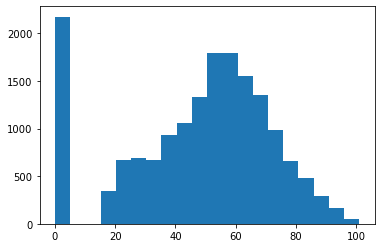

In [13]:
plt.hist(profile['age'], bins = 20)

In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            17000 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            17000 non-null  float64
 5   income_na         17000 non-null  object 
 6   age_na            17000 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 929.8+ KB


In [14]:
portfolio_id = portfolio['id'].unique()
offer_id = np.arange(len(portfolio_id))
offer_id_map = pd.DataFrame(
    {'portfolio_id': portfolio_id,
     'offer_id': offer_id
    })

In [15]:
offer_id_map

,portfolio_id,offer_id
0,ae264e3637204a6fb9bb56bc8210ddfd,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,1
2,3f207df678b143eea3cee63160fa8bed,2
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,3
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,4
5,2298d6c36e964ae4a3e7e9706d1fb8c2,5
6,fafdcd668e3743c1bb461111dcafc2a4,6
7,5a8bc65990b245e5a138643cd4eb9837,7
8,f19421c1d4aa40978ebb69ca19b0e20d,8
9,2906b810c7d4411798c6938adc9daaa5,9


In [157]:
offer_id_map['offer_id'].dtype

dtype('int64')

In [17]:
def clean_portfolio(portfolio = portfolio, offer_id_map = offer_id_map):
    """
    clean the portfolio data, change "ID" into "offer_id" according to offer_id_map
    split channels into columns
    
    
    """
    port_clean = portfolio.copy()
    channel_list = []
    for channel in portfolio['channels']:
        channel_list.extend(channel)
    channel_set = set(channel_list)
    
    # convert channels into dummies
    for channel in channel_set:
        port_clean['channel_' + channel] = port_clean['channels'].apply(lambda x: x.count(channel)>0)
        
    # change id according to offer_id_map
    
    port_clean['offer_id'] = port_clean['id'].apply(lambda x:
                            int(offer_id_map[offer_id_map['portfolio_id'] == x]['offer_id'].values))
        
    
    port_clean.drop(['channels','id'], axis = 1, inplace = True)
    return port_clean

clean_portfolio()

,reward,difficulty,duration,offer_type,channel_web,channel_mobile,channel_social,channel_email,offer_id
0,10,10,7,bogo,False,True,True,True,0
1,10,10,5,bogo,True,True,True,True,1
2,0,0,4,informational,True,True,False,True,2
3,5,5,7,bogo,True,True,False,True,3
4,5,20,10,discount,True,False,False,True,4
5,3,7,7,discount,True,True,True,True,5
6,2,10,10,discount,True,True,True,True,6
7,0,0,3,informational,False,True,True,True,7
8,5,5,5,bogo,True,True,True,True,8
9,2,10,7,discount,True,True,False,True,9


In [18]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [20]:
transcript.person.nunique()

17000

In [149]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [21]:
transcript[transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


In [28]:
portfolio_clean = clean_portfolio()

In [161]:
def clean_transcript(transcript = transcript, portfolio = clean_portfolio, offer_id_map = offer_id_map):
    """
    clean the transcript data, use person_id, offer_id instead of hash number.
    
    Parameters
    ------------
    
    
    Returns
    ------------
    
    
    """
    
    # simplify person to person_id
    transcript_clean = transcript.copy()    
    person_id_map = pd.DataFrame(
        {'person':transcript_clean['person'].unique(),
         'person_id': np.arange(transcript_clean['person'].nunique())
        })
    transcript_clean = transcript_clean.merge(person_id_map, on = 'person')    
    print(transcript_clean.event.unique())
    # 
    
    transcript_clean['portfolio_id'] = transcript_clean['value'].apply(
        lambda x : x.get('offer_id', np.nan) if (x.get('offer id', np.nan) is np.nan) else x.get('offer id', np.nan)
    )


    transcript_clean['amount'] = transcript_clean['value'].apply(lambda x :x.get('amount', np.nan))

    transcript_clean['reward'] = transcript_clean['value'].apply(lambda x :x.get('reward', np.nan))
    transcript_clean = transcript_clean.merge(offer_id_map,how = 'left', on = 'portfolio_id')
    transcript_clean.drop(['person','value', 'portfolio_id'], axis = 1, inplace = True)

    return transcript_clean

clean_trans = clean_transcript()
clean_trans.head()

['offer received' 'offer viewed' 'transaction' 'offer completed']


,event,time,person_id,amount,reward,offer_id
0,offer received,0,0,NaN,NaN,3.0
1,offer viewed,6,0,NaN,NaN,3.0
2,transaction,132,0,19.89,NaN,NaN
3,offer completed,132,0,NaN,5.0,3.0
4,transaction,144,0,17.78,NaN,NaN


In [159]:
clean_trans['offer_id'].dtype

dtype('float64')

In [130]:
clean_trans['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [155]:
def create_matrix(data):
    event_offer_cp = data['event'] == 'offer completed'
    event_offer_re = data['event'] == 'offer received'
    event_offer_vi = data['event'] == 'offer viewed' 
    event_offer_ta = data['event'] == 'offer transaction' 
    
    # count completed offer
    offer_completed_count = data[event_offer_cp].groupby(['person_id', 'offer_id'])['person_id'].count().unstack(1)
    offer_completed_count = offer_completed_count.add_suffix('_completed')
    # count received offer
    offer_received_count = data[event_offer_re].groupby(['person_id', 'offer_id'])['person_id'].count().unstack(1)
    offer_received_count = offer_received_count.add_suffix('_received')    
    
    feature_matrix = offer_completed_count.merge(offer_received_count, on = 'person_id')
    return feature_matrix
trans_feature = create_matrix(clean_trans)
trans_feature.head()

offer_id,0.0_completed,1.0_completed,3.0_completed,4.0_completed,5.0_completed,6.0_completed,8.0_completed,9.0_completed,0.0_received,1.0_received,2.0_received,3.0_received,4.0_received,5.0_received,6.0_received,7.0_received,8.0_received,9.0_received
person_id,,,,,,,,,,,,,,,,,,
0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN
2,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0
5,NaN,NaN,1.0,NaN,NaN,1.0,2.0,1.0,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,2.0,1.0
6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN


In [140]:
event_offer_cp = clean_trans['event'] == 'offer completed'
event_offer_re = clean_trans['event'] == 'offer received'
event_offer_vi = clean_trans['event'] == 'offer viewed'
clean_trans[event_offer_cp].groupby(['person_id', 'offer_id'])['person_id'].count().unstack(1)

offer_id,0,1,3,4,5,6,8,9
person_id,,,,,,,,
0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN
2,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
5,NaN,NaN,1.0,NaN,NaN,1.0,2.0,1.0
6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...
16984,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
16987,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN
16988,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [112]:
clean_trans.iloc[3,1].get('offer_id')
clean_trans.portfolio_id.describe()
problem = clean_trans[clean_trans['portfolio_id'].isna()]
problem.head()

,event,value,time,person_id,portfolio_id,ammount
2,transaction,{'amount': 19.89},132,0,NaN,19.89
4,transaction,{'amount': 17.78},144,0,NaN,17.78
7,transaction,{'amount': 19.67},222,0,NaN,19.67
8,transaction,{'amount': 29.72},240,0,NaN,29.72
9,transaction,{'amount': 23.93},378,0,NaN,23.93


In [107]:
problem['value'].apply(lambda x :x.keys(r'offer_[ ]id'))

TypeError: dict.keys() takes no arguments (1 given)

In [76]:
def get_id(dict):
    return dict['offer id']
    event_offer_list = transcript['event'].str.find('offer')>-1
transcript.loc[:2,'value'].apply(lambda x:x['offer id'])

0    9b98b8c7a33c4b65b9aebfe6a799e6d9
1    0b1e1539f2cc45b7b9fa7c272da2e1d7
2    2906b810c7d4411798c6938adc9daaa5
Name: value, dtype: object

In [70]:
transcript['value'].apply(lambda x :x.get('offer id'))

0         9b98b8c7a33c4b65b9aebfe6a799e6d9
1         0b1e1539f2cc45b7b9fa7c272da2e1d7
2         2906b810c7d4411798c6938adc9daaa5
3         fafdcd668e3743c1bb461111dcafc2a4
4         4d5c57ea9a6940dd891ad53e9dbe8da0
                        ...               
306529                                None
306530                                None
306531                                None
306532                                None
306533                                None
Name: value, Length: 306534, dtype: object

In [65]:
a = transcript['value'][event_offer_list]
a.head()
a.head().apply(lambda x: x['offer id'])

Series([], Name: value, dtype: object)

In [82]:
transcript.iloc[3,2]

{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}